## Survival Analysis

In [6]:
## Survival analysis gives us the probability that an event has not occured at Time T

In [1]:
## Importing the necessary analysis

import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter,CoxPHFitter
import matplotlib.pyplot as plt
from lifelines.datasets import load_dd

#### Data Exploration

In [16]:
## Load the dataframe
## The dataframe summarises the duration each president in a geographical location stays in Office

data =load_dd()
data.head()  ## Top 5 columns

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


In [4]:
data.tail()   ##  Bottom 5 columns

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
1803,Zambia,551,551.0,Eastern Africa,Africa,Levy Patrick Mwanawasa,Levy Patrick Mwanawasa.Zambia.2002.2007.Civili...,Non-democracy,Civilian Dict,2002,6,1
1804,Zambia,551,551.0,Eastern Africa,Africa,Rupiah Bwezani Banda,Rupiah Bwezani Banda.Zambia.2008.2008.Civilian...,Non-democracy,Civilian Dict,2008,1,0
1805,Zimbabwe,552,552.0,Eastern Africa,Africa,Ian Smith,Ian Smith.Zimbabwe.1965.1978.Civilian Dict,Non-democracy,Civilian Dict,1965,14,1
1806,Zimbabwe,552,552.0,Eastern Africa,Africa,Abel Muzorewa,Abel Muzorewa.Zimbabwe.1979.1979.Civilian Dict,Non-democracy,Civilian Dict,1979,1,1
1807,Zimbabwe,552,552.0,Eastern Africa,Africa,Robert Mugabe,Robert Mugabe.Zimbabwe.1980.2008.Civilian Dict,Non-democracy,Civilian Dict,1980,29,0


In [5]:
## To ascertain our censored values count
## Censored observations are obs that we have not been able to ascertained when the expected event occurs

data.observed.value_counts()

1    1468
0     340
Name: observed, dtype: int64

#### Extract our Duration and Event

In [8]:
T =data['duration']
E =data['observed']
kmf=KaplanMeierFitter()   ## The non-parametric model we will be using

In [9]:
## Train our model
kmf.fit(T,event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1808 total observations, 340 right-censored observations>

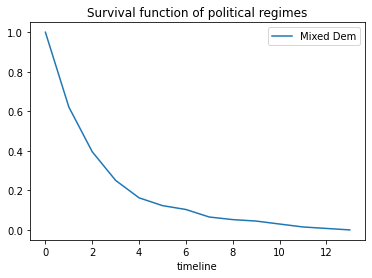

In [32]:
## Plotting the Survival Function of the dataframe
## Which shows the probability that an event has not occured at a time T

kmf.survival_function_.plot()
plt.title('Survival function of political regimes');

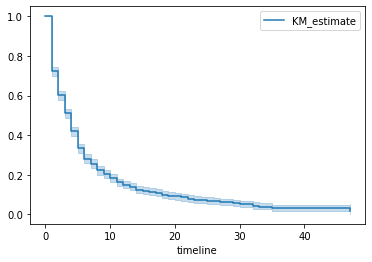

In [11]:
kmf.plot_survival_function(); ## Plotting confidence intervals

In [12]:
kmf.median_survival_time_ ## Median time of surviving in office

4.0

In [15]:
## Confidence Interval of the median survival time

from lifelines.utils import median_survival_times
median_ci = median_survival_times(kmf.confidence_interval_)
median_ci

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,3.0,4.0


#### Splitting Our data into Democracy & Non-Democracy

In [18]:
data.democracy.value_counts()

Democracy        1187
Non-democracy     621
Name: democracy, dtype: int64

The median survival time for a Democratic Govt is 3.0
The median survival time for a Non-Democratic Govt is 6.0


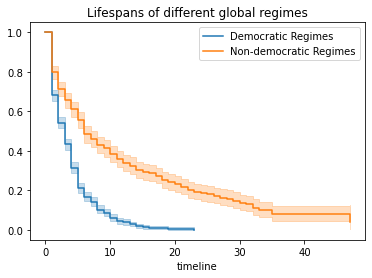

In [43]:
## Plotting Survival Function for Democracy and Non Democracy

ax = plt.subplot(1,1,1)

dem = (data['democracy'] == 'Democracy')
kmf.fit (T[dem], event_observed=E[dem], label="Democratic Regimes")
kmf.plot_survival_function(ax=ax)
print(f'The median survival time for a Democratic Govt is {kmf.median_survival_time_}')

kmf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
kmf.plot_survival_function(ax=ax)
print(f'The median survival time for a Non-Democratic Govt is {kmf.median_survival_time_}')

plt.title("Lifespans of different global regimes");

In [23]:
### Although there is a clear difference in the survival function, the log_rank test aids us to statistically confirm that by rejecting the null hypothesis
### The null hypothesis is that there is no difference between the populations in the probability of an event
### The null hypothesis is that both groups have the same Survival distribution curve
### And the P value will enable us ascertain if to reject or retain the null hypothesis

from lifelines.statistics import logrank_test
results_ =logrank_test(T[dem], T[~dem],E[dem], E[~dem],alpha=0.99)
results_.print_summary()

## P value is less than 0.005, thus we reject the null hypothesis

C:\Users\IamFavoured\anaconda3\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         260.47 <0.005    192.23

#### Plotting the survival function for the different Regime types

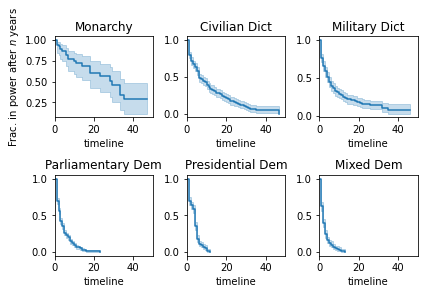

In [25]:
regime_types =data['regime'].unique()

for i,regime_type in enumerate(regime_types):
    ax =plt.subplot(2,3,i+1)
    ix=data['regime'] == regime_type
    kmf.fit(T[ix],E[ix], label=regime_type)
    kmf.plot_survival_function(ax=ax, legend=False)
    
    plt.title(regime_type)
    plt.xlim(0,50)
    
    if i ==0:
        plt.ylabel('Frac. in power after $n$ years')
        
plt.tight_layout()

In [26]:
regime_types

array(['Monarchy', 'Civilian Dict', 'Military Dict', 'Parliamentary Dem',
       'Presidential Dem', 'Mixed Dem'], dtype=object)

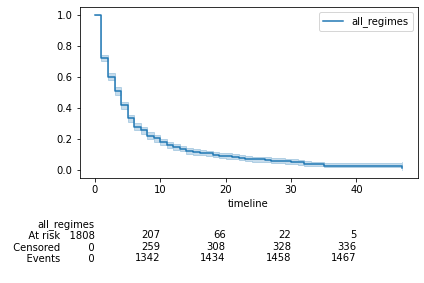

In [44]:
### Summary Table

kmf = KaplanMeierFitter().fit(T,E,label='all_regimes')
kmf.plot_survival_function(at_risk_counts=True)
plt.tight_layout();

#### Hazard Function

In [49]:
### Hazard Rate : the risk associated with the event occuring at a particular time

T= data['duration']
E=data['observed']

from lifelines import NelsonAalenFitter  ## The model
naf =NelsonAalenFitter()  ## Instantiate the model
naf.fit(T,event_observed=E) ## Fit the model

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 1808 total observations, 340 right-censored observations>

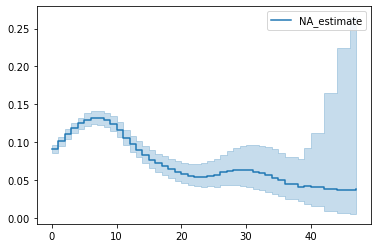

In [50]:
## Plot the Hazard function curve
naf.plot_hazard(10);  

<AxesSubplot:xlabel='timeline'>

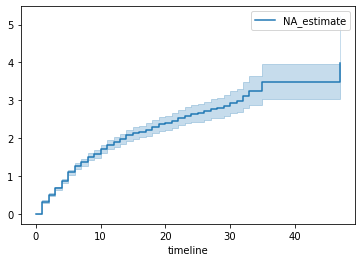

In [51]:
## The cummulative Harzard function curve
naf.plot_cumulative_hazard()

In [115]:
data.duration.unique()

array([ 7, 10,  5,  1,  6,  4,  8, 39,  3, 13,  2, 11, 30,  9, 17, 19, 28,
       14, 15, 20, 35, 18, 25, 22, 12, 27, 33, 47, 32, 16, 42, 29, 21, 26,
       24, 40, 23, 38, 46, 44, 36, 31, 34], dtype=int64)

#### Weibull Parametric :Parametric model

In [58]:
from lifelines import WeibullFitter
from lifelines.datasets import load_waltons

In [62]:
data =load_waltons()
data.head()

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137


In [63]:
data.E.value_counts()

1    156
0      7
Name: E, dtype: int64

In [64]:
T= data['T']
E =data['E']
wf= WeibullFitter().fit(T,E)

C:\Users\IamFavoured\anaconda3\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 163 total observations, 7 right-censored observations>
   number of observations = 163
number of events observed = 156
           log-likelihood = -672.06
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%
lambda_  55.73       1.33            53.13            58.33
rho_      3.45       0.24             2.97             3.93

          cmp to     z      p   -log2(p)
lambda_     1.00 41.26 <0.005        inf
rho_        1.00 10.07 <0.005      76.83
---
AIC = 1348.12

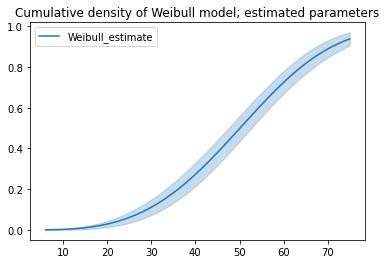

In [67]:
wf.print_summary()
ax=wf.plot_cumulative_density()
ax.set_title("Cumulative density of Weibull model; estimated parameters");

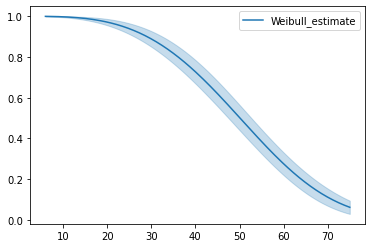

In [68]:
### Survival function curve
### It is the opposite of the cummulative density curve

wf.plot_survival_function();

### Survival Regression

In [78]:
from lifelines.datasets import load_rossi

In [79]:
### We have been dealing with the univariate approach
### The multivariate approach gives us the survival function curve as well as the effect of the variable on the survival function

rossi =load_rossi()

In [80]:
## Load the dataset
rossi =load_rossi()

In [81]:
## Lets view our data Frame
rossi.head()

## The data pertain to 432 convicts who were released from Maryland state prisons in the 1970's and
## were followed up for one year after release 

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [82]:
## Column Explanation
## week : week of rearrest
## arrest: 1- arrested; 0- not arrested
## financial aid:  1-received 0-not received
## Age: age in years at time of 1st release
## race: 1-black, 0 -other
## wexp : 1 - no fulltime work experience, 0-full time work experience
## mar: marital status at time of release- 1: married, 0-not married
## paro: released on parole: 1- no , 0- yes
## prior: number of convictions prior to current arrest

In [87]:
## Cox Proportional Hazard Model
from lifelines import CoxPHFitter

In [88]:
cph =CoxPHFitter()  ## instantiate the model

In [89]:
## Analysis summary 
## Importance lies on coef and P value
## The null hypothesis is that the features has no effect on the survival fn

cph.fit(rossi, duration_col='week',event_col='arrest')
cph.print_summary()

C:\Users\IamFavoured\anaconda3\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2022-10-04 10:46:57 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.75            -0.00                 0.47                 1.00
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.37       0.31            -0.29             0.92                 0.75                 2.50
wexp       -0.15       0.86       0.21            -0.57             0.27                 0.57                 1.30
mar        -0.43       0.65       0.38            -1.18             0.31                 0.31                 1.37
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.10       0.03             0.04             0.15                 1.04                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
fin           0.00 -1.98   0.05       4.40
age           0.00 -2.61   0.01       6.79
race          0.00  1.02   0.31       1.70
wexp          0.00 -0.71   0.48       1.06
mar           0.00 -1.14   0.26       1.97
paro          0.00 -0.43   0.66       0.59
prio          0.00  3.19 <0.005       9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

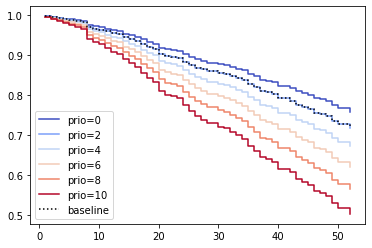

In [90]:
## Plotting the effect of varying a covariate

cph.plot_partial_effects_on_outcome(covariates='prio', values=[0,2,4,6,8,10],y='survival_function', cmap='coolwarm');